## Randomization schemes to assess the bias of model predictions.

I have been validating my model for drug prescription by comparing the predictions to randomly selected observations of patients. However, there are many possible schemes for choosing my random sample of data.  

The previous results I showed were assessed on the following scheme: I select a random set of people and a random calendar year from among the **observed calendar years** for each person. I predict for each person, prescriptions of each drug over the calendar year. I showed that for this limited case, I can make unbiased predictions. Then, I can use this as a model if this is all that is needed (this is how I am comparing drugs taken at observed years in different counties).  

However, for the goal of predicting drugs after cancer, this is inadequate. Cancer can happen in any random time, not necessarily at the beginning of a year, and not necessarily in a year with observed drugs, so we can't condition on a year being observed.  Below is an example person.  Rx of different drugs are indicated as *triangles*.  The person has repeat Rx for drug "a".  The person also has a number of Dx indicated as *pentagons*, with the first recorded cancer Dx labeled. I would like to be able to compare drugs first prescribed in the year after first Cancer diagnosis (indicated by the *red bar*), to a null model that is based only on basic characteristics of the person.  

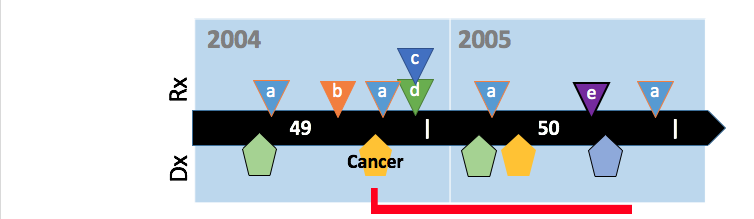

In [6]:
Image(filename='png/person_rx_dx.png',width=700)

How do I assess if the null model is unbiased? We clearly need a different randomization scheme to test the model. In the figure below, I outline a few schemes for randomly picking a year. Scheme 0 (purple) is the previous scheme of choosing a calendar year from among the observed calendar years. In each of the other schemes, the shapes indicate uniformly equally likely times for the start week of the random year-long period.

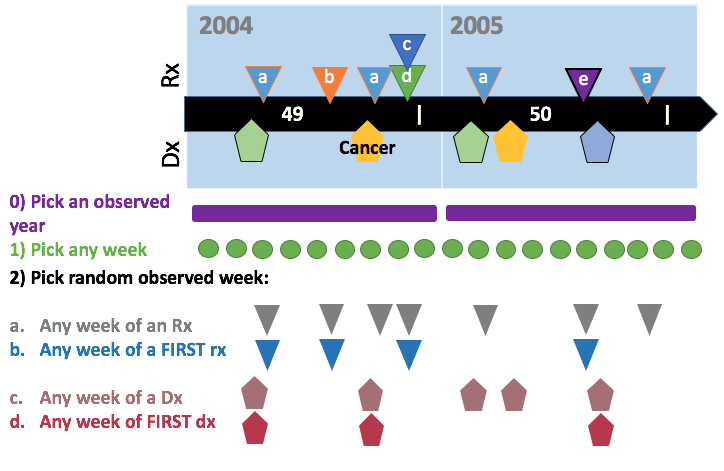

In [26]:
Image(filename='png/random_week.png',width=700)

So clearly, the model I make has to be tailored based on results from the randomization scheme I use, which has to be tailored to the goal of the prediction. 

The goal is to predict how many people will be taking a certain drug in the year after a randomly observed diagnosis.   Then I need a randomization scheme that reflects this and a model that controls for the relevant covariates:  so this should be scheme 2c or 2d. 

However, testing these schemes, I have realized that I am not adequately accounting for heterogeneity among the data observed per person. For example, here are the results of the observed (y-axis) and expected (x-axis) number of people taking the denoted drugs using scheme (2c), for 5 random trials, evaluated on the model that works for scheme (0). I ran into similar problems using the other schemes. The model is not hugely inaccurate but it is biased for some drugs.

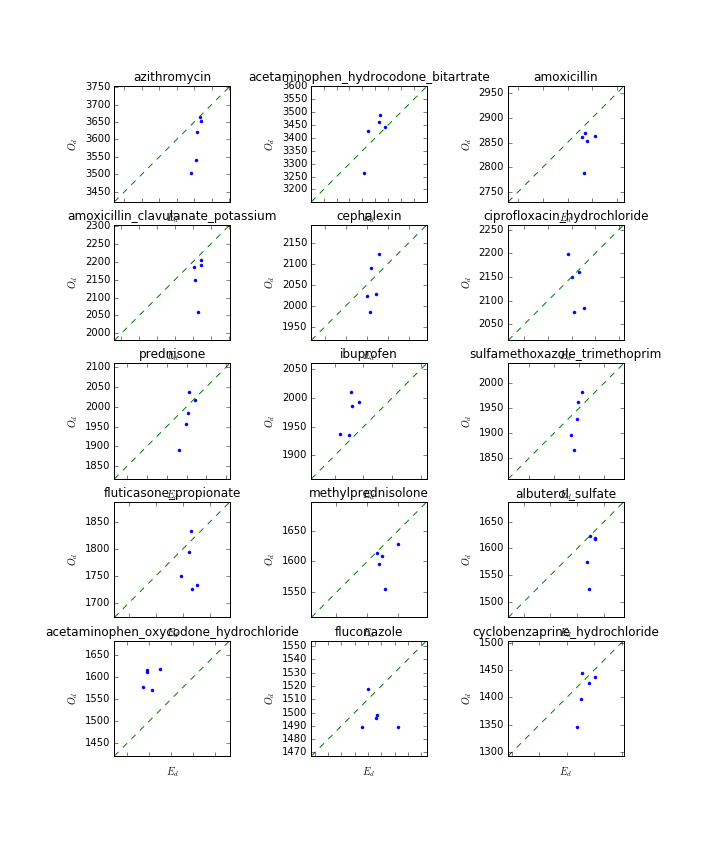

In [25]:
Image(filename='png/scheme2c.png',width=700)

The problem: as I've already dealt with, people with a different amount of data observed have a different probability of taking a drug. Thus, a randomization scheme based off of the amount of data observed can have unexpected influences on the probability of a drug, and we must account for this. 
 
For example, in making a model that is unbiased for Scheme (0), I realized I had to account for the number of years observed.  In the plot below, among people observed in year 2, in age range 40-50, I looked at the fraction of people who are first prescribed Amoxicillin, among people who had never been prescribed this drug before. The subplots divide up these people by number of first Rx observed in that year, denoted `year_urx` which ranges from {1..6} here. Obviously if someone has zero first Rx in that year, we can predict with perfect accuracy that the person did not take amoxicillin.  The overall fraction of people taking amoxicillin, given age, year, and `year_urx`, is shown by the dashed gray line per subplot. The higher `year_urx`, the higher the fraction of people taking amoxicillin.

Even conditioning on age, year, `year_urx`, there is still systematic variability among these people when you divide them up by how many calendar years in their histories contain a first-Rx of any drug. I label this covariate ** `years_observed` **.  The greater `years_observed` (x-axis per subplot), the lower the fraction taking Amoxicillin.  Below that, I show the same plot for Cephalexin, another common antibiotic, which has the opposite trend (`years_observed` positiviely correlates with more cephalexin). 

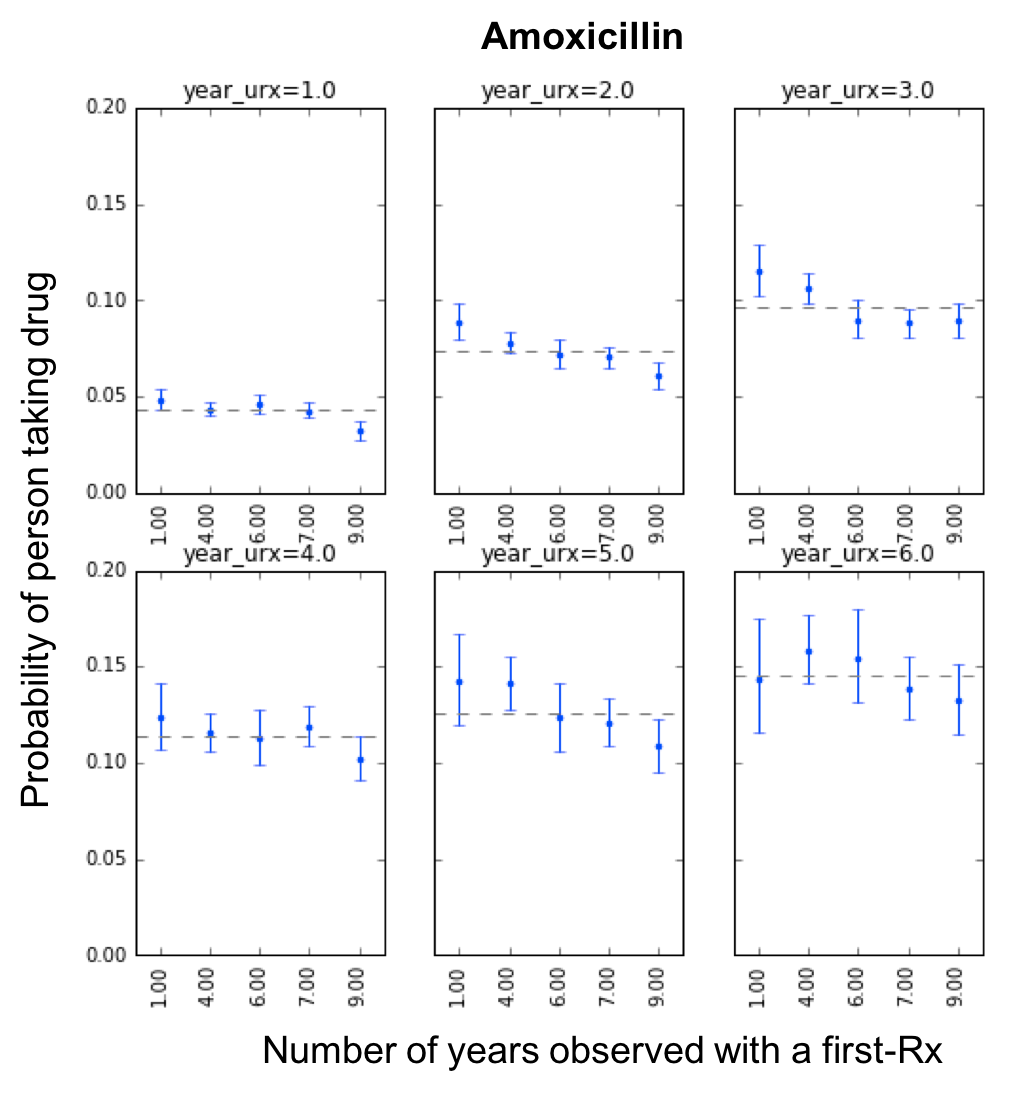

In [9]:
Image(filename='png/amoxicillin_uytot.png',width=500)

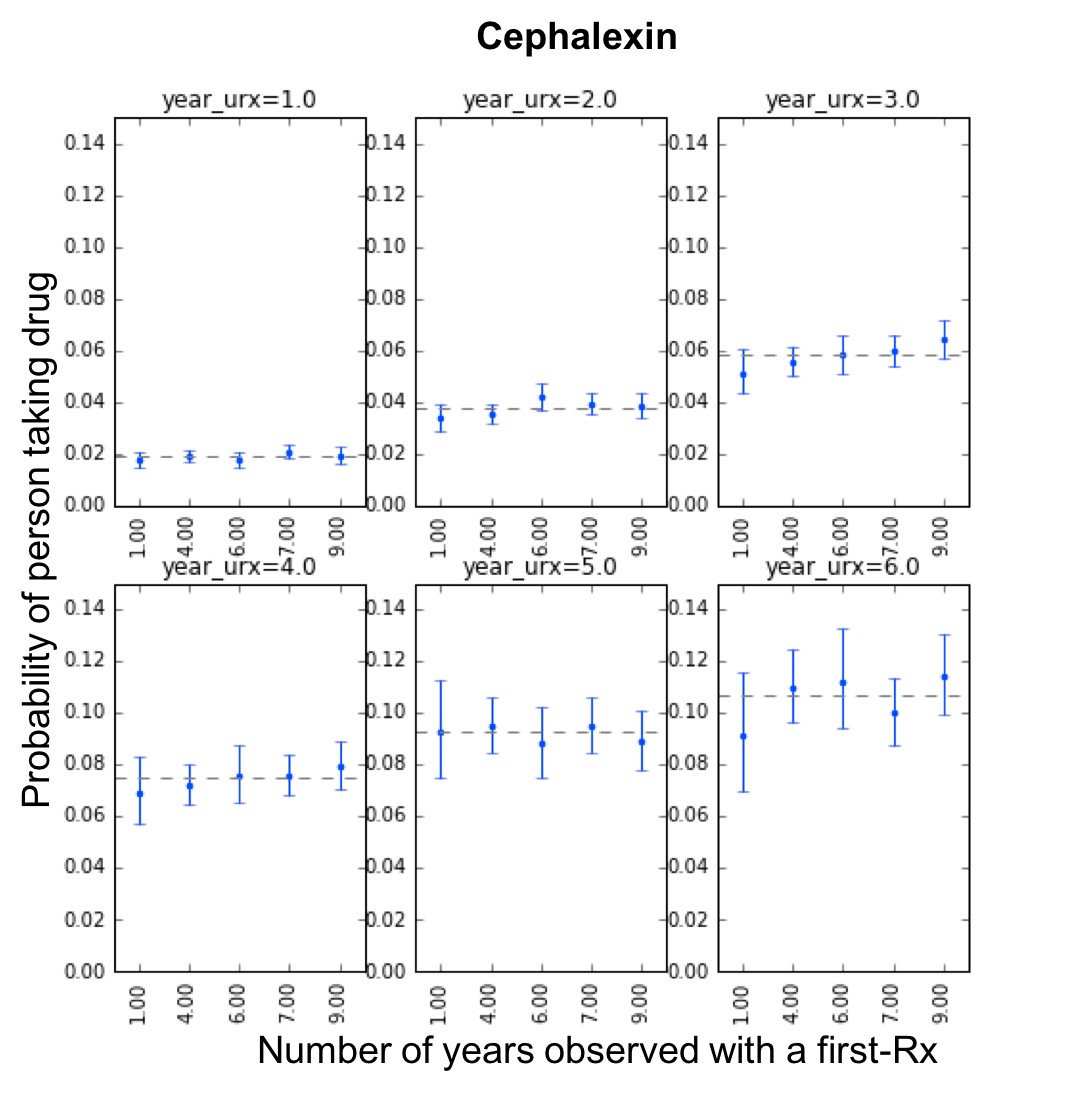

In [11]:
Image(filename='png/cephalexin_uytot.png',width=550)

I am accounting for this in my previous regression model, which includes `years_observed` as a covariate. But  other characteristics of patients  might be associated with probability of taking the drug, that might be important for Scheme 2c. To investigate I did a logistic regression among all people observed in year 2, age 40-50.  I looked particularly at amoxicillin (which is systematically over-estimated, see above) and ibuprofen (systematically under-estimated). Below, I ranked the covariates by their wald p-values: `year_urx` as shown above, is the most predictive, and `years_observed` is predictive in amoxicillin. 

Since Scheme 2c is based on time after a random Dx I also looked at covariates related to the observations of Dx:
- `total_dx`: the total number of Dx, including repeat Dx 
- `dx_this_year`: the number of Dx this year 
- `dx_this_year/total_dx`: the proportion of all Dx that happen this year. 

Notice that the signs are opposite for the parameter for `dx_this_year/total_dx` in amoxicillin versus ibuprofen: 

In [29]:
pd.read_table('png/amoxicillin_dxparameters.txt',sep=',',index_col=0).sort_values('p')

,p,param
Intercept,0.000000e+00,-2.346195
year_urx,0.000000e+00,0.199200
dx_this_year,5.603409e-38,-0.011425
dx_this_year/total_dx,1.666142e-35,-1.022608
years_observed,2.899683e-11,-0.038800
total_dx,5.302894e-04,-0.000537
years_with_dx,4.201012e-01,-0.003958


In [30]:
pd.read_table('png/ibuprofen_dxparameters.txt',sep=',',index_col=0).sort_values('p')

,p,param
Intercept,0.000000e+00,-4.101217
year_urx,0.000000e+00,0.202876
dx_this_year/total_dx,2.426064e-94,1.597025
years_with_dx,7.113607e-38,0.072696
dx_this_year,3.652092e-16,-0.006172
total_dx,7.505056e-05,-0.000590
years_observed,3.365945e-01,-0.006094


Below i plot the same relationship between `dx_this_year/total_dx` and probability of taking a drug, conditioned on number of new Rx per year (`year_urx`). People with higher fraction of Dx happening in this year are more likely to have a first-Rx for Ibuprofen and less likely to have a first-Rx for amoxicillin. I can't guess why, but the important thing is to figure out how this is affecting the results and how to fix it.

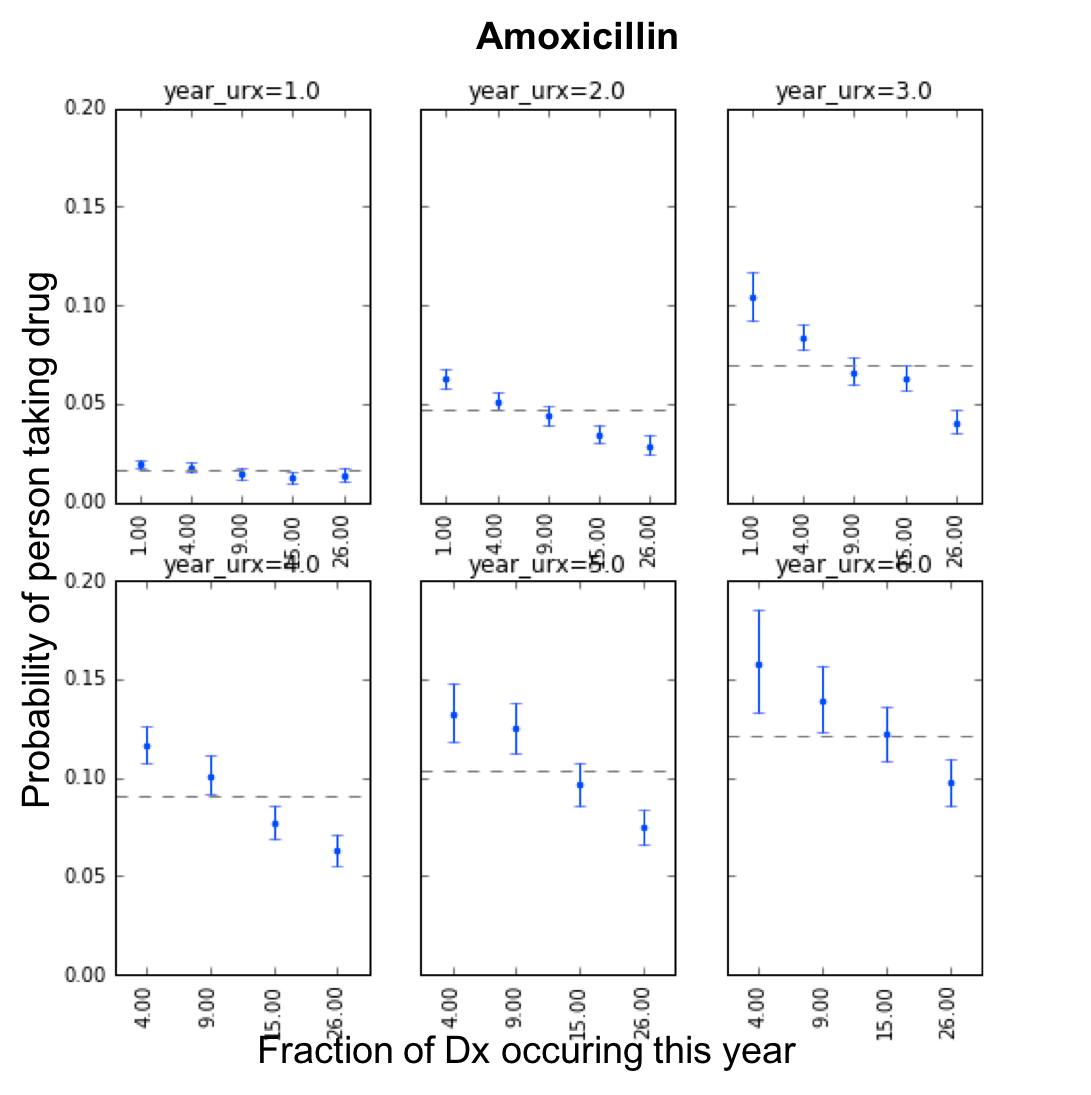

In [33]:
Image(filename='png/amoxicillin_dx_fraction.png',width=600)

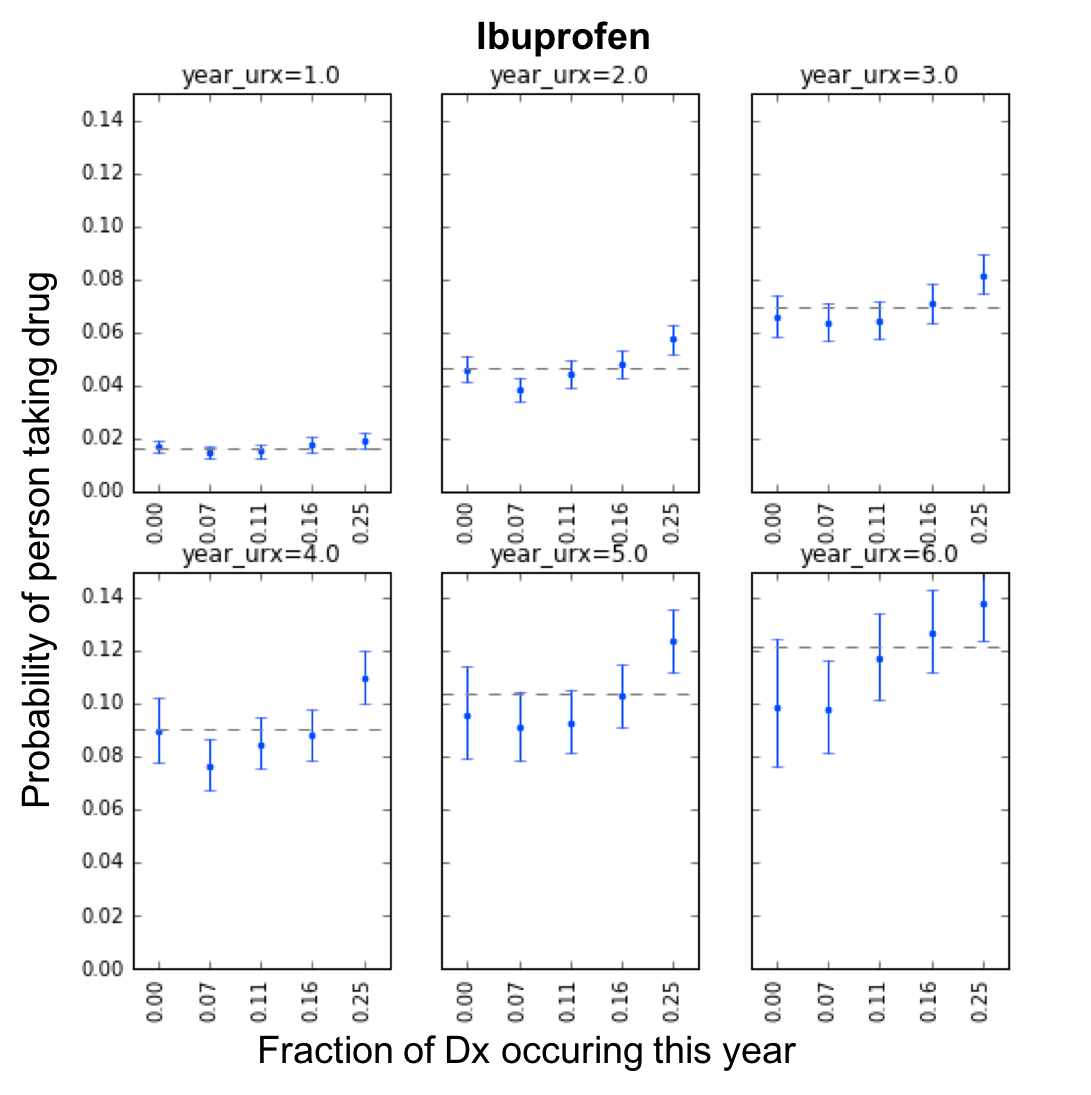

In [35]:
Image(filename='png/ibuprofen_dxfraction.png',width=600)

Below, is a sketch of how the sampling scheme, patterns of patient observations and probability of drug prescription can be associated.  Based on this, I'm trying to make a new model that accounts for the density of Dx per year. 

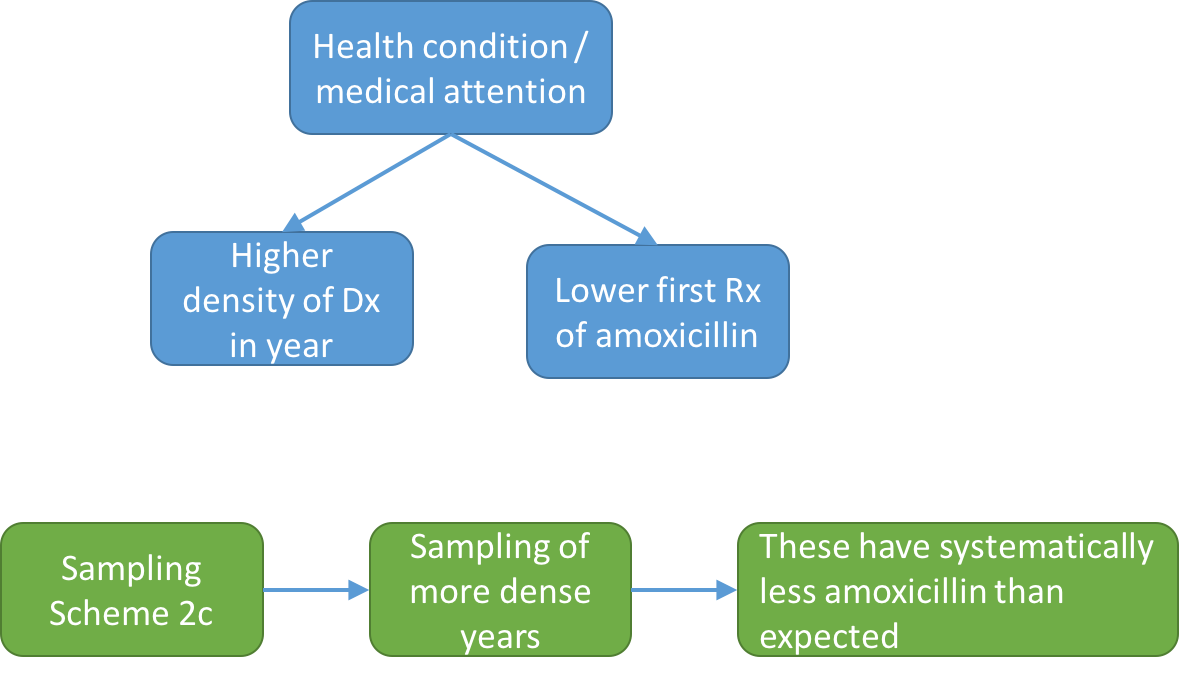

In [36]:
Image(filename='png/systematic_factors.png',width=500)

In [2]:
from IPython.display import Image